In [2]:
!pip install plotly

  Running setup.py bdist_wheel for plotly: started
  Running setup.py bdist_wheel for plotly: finished with status 'done'
  Stored in directory: C:\Users\SS\AppData\Local\pip\Cache\wheels\33\4b\2f\b3651cc3166303da7676f5724865089d32f18b8685cc04cffd
Successfully built plotly


In [16]:
!pip install nbconvert

In [5]:
py.tools.set_credentials_file(username='Shan1987', api_key='F9FbuYKZIo2bGIo5C3LU')

AttributeError: module 'plotly.plotly' has no attribute 'tools'

![G127](G1271.jpg)

Basically I will give the SQL posts a break for now and wanted to focus on something else.

People who work in Data Science tend to work in programming languages R or Python. I've been learning both languages over the last two years and at the moment I'm trying to get better at my Python. One of things people say is to get better at data science is to work on data that you have an interest in. 

One of my main passions in life has been wrestling, I've watched for the last 19 years which when you write down is actually quite scary. In this case, I decided do some analysis on Japanese Wrestling! In particular the G1 Climax tournament.

The G1 Climax is an annual Japanase wrestling tournament that's held every summer over 20 days. Rather than a simple knockout tournament it's a league made up two blocks(named A block & B block) each consisting of 20 wrestlers. The winner of each block then face off and the winner goes to headline wrestle kingdom in January.

The below allows me to showcase some of skills and explain a few things about Python

Let's start off with importing all the relevant libraries which will be updated as we go

In [23]:
import pandas as pd #standard package to work with dataframes
import numpy as np
import itertools # We use this to do some permutations to work out potential matches
import matplotlib.pyplot as plt
import seaborn as sns
import decimal
import datetime
sns.set_style('white')

Here are some potential things to look at:
Who on average has the longest time?
Does a wrestler style, weight, momemntum make a diffenece?
Does Dave Metlzer's rating correlate with match time or any other variables?
If they won the last match are they going to win the next one?


Let's start off by reading the csv file with the wrestler's names and which block they're in.

In [3]:
df = pd.read_csv("G1 Competitors.csv") #Using pandas read_csv, attached is the file

In [4]:
df.info() #use the dataframe propetry .info() to give us information on the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
A Block    10 non-null object
B Block    10 non-null object
dtypes: object(2)
memory usage: 240.0+ bytes


The information above tells us that the dataframe only contain 10 entries with No null objects which is good to see. We can just type in **df** into the console and see what the whole dataframe looks like. Of course if we had more rows we wouldn't be able to do this and would use *df.head()*

In [5]:
df

A Block          B Block
0  Hiroshi Tanahashi  Kazuchika Okada
1        Togi Makabe        Toru Yano
2     Tomohiro Ishii   Satoshi Kojima
3       Hirooki Goto    Michael Elgin
4        YOSHI-HASHI   Juice Robinson
5      Bad Luck Fale       Tama Tonga
6        Yuji Nagata           SANADA
7     Zack Sabre Jr.             EVIL
8        Kota Ibushi    Minoru Suzuki
9      Tetsuya Naito      Kenny Omega

I noticed that some of the wrestler's name have capitals while others don't. Let's convert all the names to upper case.
We use the dataframe applymap which applies a function to every cell in a dataframe and rather than writing a whole function we will just create one inside also know as an anonymous function.

In [14]:
df = df.applymap(lambda x: x.upper()) 
df # Let's print the dataframe to see if that's worked

A Block          B Block
0  HIROSHI TANAHASHI  KAZUCHIKA OKADA
1        TOGI MAKABE        TORU YANO
2     TOMOHIRO ISHII   SATOSHI KOJIMA
3       HIROOKI GOTO    MICHAEL ELGIN
4        YOSHI-HASHI   JUICE ROBINSON
5      BAD LUCK FALE       TAMA TONGA
6        YUJI NAGATA           SANADA
7     ZACK SABRE JR.             EVIL
8        KOTA IBUSHI    MINORU SUZUKI
9      TETSUYA NAITO      KENNY OMEGA

Let's now create the league tables for each block. First let's seperate the wrestler from dataframe **df** in two dataframes called **A_Block** and **B_Block**

In [17]:
A_Block = pd.DataFrame(df['A Block'])
A_Block.columns = ['Wrestler']
B_Block = pd.DataFrame(df['B Block'])
B_Block.columns = ['Wrestler']

Ok we've now got two seperate dataframes called *A_Block* & *B_Block*. Let's add the usual columns you'd see in any sports league **'Matches','Wins','Losses','Draws'**. 

I'm going to include **'Match Time'** as the total time a wrestler has competed. I'm also going to add another column called **'DMR'**, which stands for Dave Meltzer Rating. Dave Meltzer is a 30 year wrestling journalist whose ratings of matches are out of five and is held in high standing in the wrestling community. By default I've set these to NaN

In [18]:
A_Block['Matches'] = np.NAN
A_Block['Wins'] = np.NAN
A_Block['Losses'] = np.NAN
A_Block['Draws'] = np.NAN
A_Block['Points'] = np.NAN
A_Block['Match_Time'] = np.NAN
A_Block['DMR'] = 0.00
B_Block['Matches'] = np.NAN
B_Block['Wins'] = np.NAN
B_Block['Losses'] = np.NAN
B_Block['Draws'] = np.NAN
B_Block['Points'] = np.NAN
B_Block['Match_Time'] = np.NAN
B_Block['DMR'] = 0.00

In [19]:
A_Block.head(1)#lets use head to see if the table is as we want

Wrestler  Matches  Wins  Losses  Draws  Points  Match_Time  DMR
0  HIROSHI TANAHASHI      NaN   NaN     NaN    NaN     NaN         NaN  0.0

In [21]:
B_Block.head(1)#B block

Wrestler  Matches  Wins  Losses  Draws  Points  Match_Time  DMR
0  KAZUCHIKA OKADA      NaN   NaN     NaN    NaN     NaN         NaN  0.0

How many potential matches per block?
Using the old permuations formula below where my ***n=10*** & ***r=2***


$C(n,r)=\frac{n!}{(n-r)!r!}$


In [9]:
math.factorial(10)/(math.factorial(2)*math.factorial(10-2))

45.0

Ok there are 45 possible matches for each block.

I was going to write a custom function to list all these possible matches but luckily the python community is so large someone has already done this for me! The function is within the python library itertools. We use the function combinations as we're looking for all unique combinations and not permutations. The combination takes a list as a paremeter so we can't simply pass in the data frame and we need to select the Wrestler column as a series.

Using the combination function I'll create two new dataframes called **A_matches** and **B_matches**

In [25]:
A_matches = pd.DataFrame.from_records(list(itertools.combinations(A_Block['Wrestler'],2)), columns = ['Wrestler 1', 'Wrestler 2'])
B_matches = pd.DataFrame.from_records(list(itertools.combinations(B_Block['Wrestler'],2)), columns = ['Wrestler 1', 'Wrestler 2'])
A_matches.head()

Wrestler 1      Wrestler 2
0  HIROSHI TANAHASHI     TOGI MAKABE
1  HIROSHI TANAHASHI  TOMOHIRO ISHII
2  HIROSHI TANAHASHI    HIROOKI GOTO
3  HIROSHI TANAHASHI     YOSHI-HASHI
4  HIROSHI TANAHASHI   BAD LUCK FALE

Ok we've got all the potential matches for each block. Let's add a few more columns to this mathches. Let's add the columns **Winner, Loser, Match_Time, Draw, DMR**. We've also added a match counter column labelled **Match**

In [26]:
A_matches['Winner'] = np.NAN
B_matches['Winner'] = np.NAN
A_matches['Loser'] = np.NAN
B_matches['Loser'] = np.NAN
A_matches['Match'] = 1
B_matches['Match'] = 1
B_matches['Match_Time'] = np.NAN
A_matches['Match_Time'] = np.NAN
B_matches['Draw'] = False
A_matches['Draw'] = False
B_matches['DMR'] = 0.00
A_matches['DMR'] = 0.00

In [27]:
A_matches.head(5)

Wrestler 1      Wrestler 2  Winner  Loser  Match  Match_Time   Draw  \
0  HIROSHI TANAHASHI     TOGI MAKABE     NaN    NaN      1         NaN  False   
1  HIROSHI TANAHASHI  TOMOHIRO ISHII     NaN    NaN      1         NaN  False   
2  HIROSHI TANAHASHI    HIROOKI GOTO     NaN    NaN      1         NaN  False   
3  HIROSHI TANAHASHI     YOSHI-HASHI     NaN    NaN      1         NaN  False   
4  HIROSHI TANAHASHI   BAD LUCK FALE     NaN    NaN      1         NaN  False   

   DMR  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0

In [28]:
B_matches.head(5)

Wrestler 1      Wrestler 2  Winner  Loser  Match  Match_Time   Draw  \
0  KAZUCHIKA OKADA       TORU YANO     NaN    NaN      1         NaN  False   
1  KAZUCHIKA OKADA  SATOSHI KOJIMA     NaN    NaN      1         NaN  False   
2  KAZUCHIKA OKADA   MICHAEL ELGIN     NaN    NaN      1         NaN  False   
3  KAZUCHIKA OKADA  JUICE ROBINSON     NaN    NaN      1         NaN  False   
4  KAZUCHIKA OKADA      TAMA TONGA     NaN    NaN      1         NaN  False   

   DMR  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0

Ok we now have a table of the potential matches, I decided to write two functions, one that updates the Match dataframes with the results and the other to update the league table. I didn't want to type out the full names either as the spellings of Japanese names can be quite hard. So the function does a partial match and prints out the names it's matched as a check

In [29]:
def updateresults(df,winner,loser, time, DMR, draw = False):#We want to find the index for the match for these two wrestlers
    winner = winner.upper() #Tidy up the names
    loser = loser.upper()
    # Search for them in the results table and return their position
    #I really should an error handler but I'm being lazy and this function is a one time use
    w1 = list(df[df['Wrestler 1'].str.contains(winner)].index) 
    w2 = list(df[df['Wrestler 2'].str.contains(winner)].index)
    w3 = w1 + w2
    if not w1:
        winner = df.iloc[w2[0],1]
    else:
        winner = df.iloc[w1[0],0]
    
    l1 = list(df[df['Wrestler 1'].str.contains(loser)].index)
    l2 = list(df[df['Wrestler 2'].str.contains(loser)].index)
    l3 = l1 + l2
    if not l1:
        loser = df.iloc[l2[0],1]
    else:
        loser = df.iloc[l1[0],0]
    i = list(set(w3).intersection(l3))
    i = i[0]
    print(winner + ',' +loser)
    df.iloc[i,5] = time
    df.iloc[i,7] = DMR
    #if it's draw add none to winner & loser and turn the draw value to True
    if draw == False:
        df.iloc[i,2] = winner
        df.iloc[i,3] = loser
    else:
        df.iloc[i,2] = 'None'
        df.iloc[i,3] = 'None'
        df.iloc[i,6] = True       
    updatetable()
 



In [30]:
def updatetable():# Function to update the table standings after match results
    global A_Block
    global B_Block
    cols = ['Matches','Wins','Losses','Draws','Points']
    
    A_Block['Wins'] = A_Block['Wrestler'].map(A_matches['Winner'].value_counts())
    A_Block['Losses'] = A_Block['Wrestler'].map(A_matches['Loser'].value_counts())
    x = A_matches.loc[A_matches.Draw == True, ['Wrestler 1','Wrestler 2']]
    Draws = (pd.concat([x['Wrestler 1'],x['Wrestler 2']]))
    A_Block['Draws'] = A_Block['Wrestler'].map(Draws.value_counts())
    A_Block = A_Block.fillna(0)#replace the nan's with zeroes so we can tally later
    A_Block['Matches'] = A_Block['Wins'] + A_Block['Losses'] + A_Block['Draws']
    A_Block['Points'] = A_Block['Wins']*2 + A_Block['Draws']
    a=A_matches[['Wrestler 1','DMR']]
    b=A_matches[['Wrestler 2','DMR']]
    a.columns = ['Wrestler','DMR']
    b.columns = ['Wrestler','DMR']
    c = [a,b]
    d = pd.concat(c)
    ratings  = d.groupby('Wrestler').mean().reset_index()
    A_Block['DMR'] = A_Block['Wrestler'].map(ratings.set_index('Wrestler')['DMR'])
    A_Block = A_Block.sort_values(['Points'],ascending=False).reset_index(drop=True)
    A_Block[cols] = A_Block[cols].applymap(np.int64)
    
    
    
    B_Block['Wins'] = B_Block['Wrestler'].map(B_matches['Winner'].value_counts())
    B_Block['Losses'] = B_Block['Wrestler'].map(B_matches['Loser'].value_counts())
    x =B_matches.loc[B_matches.Draw == True, ['Wrestler 1','Wrestler 2']]
    Draws = (pd.concat([x['Wrestler 1'],x['Wrestler 2']]))
    B_Block['Draws'] = B_Block['Wrestler'].map(Draws.value_counts())    
    B_Block = B_Block.fillna(0)#replace the nan's with zeroes so we can tally later
    B_Block['Matches'] = B_Block['Wins'] + B_Block['Losses'] + B_Block['Draws']
    B_Block['Points'] = B_Block['Wins']*2 + B_Block['Draws']
    a=B_matches[['Wrestler 1','DMR']]
    b=B_matches[['Wrestler 2','DMR']]
    a.columns = ['Wrestler','DMR']
    b.columns = ['Wrestler','DMR']
    c = [a,b]
    d = pd.concat(c)
    ratings  = d.groupby('Wrestler').mean().reset_index()
    B_Block['DMR'] = B_Block['Wrestler'].map(ratings.set_index('Wrestler')['DMR'])
    B_Block = B_Block.sort_values(['Points'],ascending=False).reset_index(drop=True)
    B_Block[cols] = B_Block[cols].applymap(np.int64)

As a test let's update our dataframes with Day 1 results. I was surprised to see Zack Sabre win over Tanahashi considering he's like the Japan John Cena. If you didn't understand that I don't think you'd be reading this!

In [31]:
updateresults(A_matches, 'YOSHI', 'Nagata', '16:29',4.25)# Day 1
updateresults(A_matches, 'Fale', 'Togi', '09:25',3.50)
updateresults(A_matches, 'Hirooki', 'Tomohiro', '13:43',4.25)
updateresults(A_matches, 'Zack', 'Tanahashi', '17:18',4.25)
updateresults(A_matches, 'Tetsuya', 'Kota', '24:41',4.75)

YOSHI-HASHI,YUJI NAGATA
BAD LUCK FALE,TOGI MAKABE
HIROOKI GOTO,TOMOHIRO ISHII
ZACK SABRE JR.,HIROSHI TANAHASHI
TETSUYA NAITO,KOTA IBUSHI


In [41]:
A_matches

Wrestler 1      Wrestler 2             Winner              Loser  \
0   HIROSHI TANAHASHI     TOGI MAKABE  HIROSHI TANAHASHI        TOGI MAKABE   
1   HIROSHI TANAHASHI  TOMOHIRO ISHII  HIROSHI TANAHASHI     TOMOHIRO ISHII   
2   HIROSHI TANAHASHI    HIROOKI GOTO  HIROSHI TANAHASHI       HIROOKI GOTO   
3   HIROSHI TANAHASHI     YOSHI-HASHI  HIROSHI TANAHASHI        YOSHI-HASHI   
4   HIROSHI TANAHASHI   BAD LUCK FALE  HIROSHI TANAHASHI      BAD LUCK FALE   
5   HIROSHI TANAHASHI     YUJI NAGATA  HIROSHI TANAHASHI        YUJI NAGATA   
6   HIROSHI TANAHASHI  ZACK SABRE JR.     ZACK SABRE JR.  HIROSHI TANAHASHI   
7   HIROSHI TANAHASHI     KOTA IBUSHI        KOTA IBUSHI  HIROSHI TANAHASHI   
8   HIROSHI TANAHASHI   TETSUYA NAITO      TETSUYA NAITO  HIROSHI TANAHASHI   
9         TOGI MAKABE  TOMOHIRO ISHII     TOMOHIRO ISHII        TOGI MAKABE   
10        TOGI MAKABE    HIROOKI GOTO        TOGI MAKABE       HIROOKI GOTO   
11        TOGI MAKABE     YOSHI-HASHI        TOGI MAKABE        YOSHI-HASHI   
12        TOGI MAKABE   BAD LUCK FALE      BAD LUCK FALE        TOGI MAKABE   
13        TOGI MAKABE     YUJI NAGATA        TOGI MAKABE        YUJI NAGATA   
14        TOGI MAKABE  ZACK SABRE JR.     ZACK SABRE JR.        TOGI MAKABE   
15        TOGI MAKABE     KOTA IBUSHI        TOGI MAKABE        KOTA IBUSHI   
16        TOGI MAKABE   TETSUYA NAITO      TETSUYA NAITO        TOGI MAKABE   
17     TOMOHIRO ISHII    HIROOKI GOTO       HIROOKI GOTO     TOMOHIRO ISHII   
18     TOMOHIRO ISHII     YOSHI-HASHI     TOMOHIRO ISHII        YOSHI-HASHI   
19     TOMOHIRO ISHII   BAD LUCK FALE      BAD LUCK FALE     TOMOHIRO ISHII   
20     TOMOHIRO ISHII     YUJI NAGATA     TOMOHIRO ISHII        YUJI NAGATA   
21     TOMOHIRO ISHII  ZACK SABRE JR.     ZACK SABRE JR.     TOMOHIRO ISHII   
22     TOMOHIRO ISHII     KOTA IBUSHI        KOTA IBUSHI     TOMOHIRO ISHII   
23     TOMOHIRO ISHII   TETSUYA NAITO     TOMOHIRO ISHII      TETSUYA NAITO   
24       HIROOKI GOTO     YOSHI-HASHI       HIROOKI GOTO        YOSHI-HASHI   
25       HIROOKI GOTO   BAD LUCK FALE      BAD LUCK FALE       HIROOKI GOTO   
26       HIROOKI GOTO     YUJI NAGATA       HIROOKI GOTO        YUJI NAGATA   
27       HIROOKI GOTO  ZACK SABRE JR.       HIROOKI GOTO     ZACK SABRE JR.   
28       HIROOKI GOTO     KOTA IBUSHI       HIROOKI GOTO        KOTA IBUSHI   
29       HIROOKI GOTO   TETSUYA NAITO      TETSUYA NAITO       HIROOKI GOTO   
30        YOSHI-HASHI   BAD LUCK FALE        YOSHI-HASHI      BAD LUCK FALE   
31        YOSHI-HASHI     YUJI NAGATA        YOSHI-HASHI        YUJI NAGATA   
32        YOSHI-HASHI  ZACK SABRE JR.     ZACK SABRE JR.        YOSHI-HASHI   
33        YOSHI-HASHI     KOTA IBUSHI        KOTA IBUSHI        YOSHI-HASHI   
34        YOSHI-HASHI   TETSUYA NAITO      TETSUYA NAITO        YOSHI-HASHI   
35      BAD LUCK FALE     YUJI NAGATA      BAD LUCK FALE        YUJI NAGATA   
36      BAD LUCK FALE  ZACK SABRE JR.     ZACK SABRE JR.      BAD LUCK FALE   
37      BAD LUCK FALE     KOTA IBUSHI      BAD LUCK FALE        KOTA IBUSHI   
38      BAD LUCK FALE   TETSUYA NAITO      BAD LUCK FALE      TETSUYA NAITO   
39        YUJI NAGATA  ZACK SABRE JR.        YUJI NAGATA     ZACK SABRE JR.   
40        YUJI NAGATA     KOTA IBUSHI        KOTA IBUSHI        YUJI NAGATA   
41        YUJI NAGATA   TETSUYA NAITO      TETSUYA NAITO        YUJI NAGATA   
42     ZACK SABRE JR.     KOTA IBUSHI        KOTA IBUSHI     ZACK SABRE JR.   
43     ZACK SABRE JR.   TETSUYA NAITO      TETSUYA NAITO     ZACK SABRE JR.   
44        KOTA IBUSHI   TETSUYA NAITO      TETSUYA NAITO        KOTA IBUSHI   

    Match Match_Time   Draw   DMR  
0       1      13:34  False  3.50  
1       1      23:30  False  4.50  
2       1       1:22  False  3.25  
3       1      13:34  False  3.75  
4       1      11:05  False  3.50  
5       1      14:47  False  4.50  
6       1      17:18  False  4.25  
7       1      20:40  False  4.75  
8       1      26:41  False  5.00  
9       1      1

In [36]:
A_Block

Wrestler  Matches  Wins  Losses  Draws  Points  Match_Time  \
0        YOSHI-HASHI        1     1       0      0       2         0.0   
1      BAD LUCK FALE        1     1       0      0       2         0.0   
2       HIROOKI GOTO        1     1       0      0       2         0.0   
3     ZACK SABRE JR.        1     1       0      0       2         0.0   
4      TETSUYA NAITO        1     1       0      0       2         0.0   
5  HIROSHI TANAHASHI        1     0       1      0       0         0.0   
6        TOGI MAKABE        1     0       1      0       0         0.0   
7     TOMOHIRO ISHII        1     0       1      0       0         0.0   
8        YUJI NAGATA        1     0       1      0       0         0.0   
9        KOTA IBUSHI        1     0       1      0       0         0.0   

        DMR  
0  0.472222  
1  0.388889  
2  0.472222  
3  0.472222  
4  0.527778  
5  0.472222  
6  0.388889  
7  0.472222  
8  0.472222  
9  0.527778

I'm going to update all the other matches in the below

In [95]:
updateresults(B_matches,'Juice','Satoshi', '11:48',3.5) # Day 2
updateresults(B_matches,'Tonga','Elgin', '13:46',3.25)
updateresults(B_matches,'Sanada','Evil','15:48',4.00)
updateresults(B_matches,'Okada','Yano', '10:31',3.25)
updateresults(B_matches,'Omega','Suzuki','21:24',4.75)

updateresults(A_matches, 'Hirooki', 'Nagata', '15:02',4.50)# Day3
updateresults(A_matches,'ISHII', 'Togi', '15:51',4.50)
updateresults(A_matches,'Ibushi', 'Zack', '15:51',4.50)
updateresults(A_matches,'Tanaha', 'Fale', '11:05',3.50)
updateresults(A_matches,'Tetsuya', 'Yoshi', '22:19',4.25)

updateresults(B_matches, 'Yano', 'Kojima','09:12',1.50) # Day 4
updateresults(B_matches, 'Evil', 'Juice','11:46',4.00)
updateresults(B_matches, 'Suzuki', 'Sanada','11:22',3.75)
updateresults(B_matches, 'Omega', 'Tama','11:42',3.50)
updateresults(B_matches, 'Okada', 'Elgin','25:49',4.75)


updateresults(A_matches, 'Zack', 'Yoshi','11:48',3.50) # Day 5
updateresults(A_matches, 'Hiroshi', 'YUji', '14:47',4.50)
updateresults(A_matches, 'Fale', 'Tetsuya', '11:55',2.50)
updateresults(A_matches, 'Kota', 'Ishii', '17:14',4.50)
updateresults(A_matches, 'Togi', 'Hirooki','16:55',4.00)

updateresults(B_matches, 'Elgin', 'Kojima','13:09',3.75) # Day 6
updateresults(B_matches, 'Evil', 'Tonga','10:27',2.75)
updateresults(B_matches, 'Suzuki', 'Juice', '11:23',3.25)
updateresults(B_matches, 'Omega', 'Yano', '11:31',1.00)
updateresults(B_matches, 'Okada', 'Sanada', '20:49',4.25)


updateresults(A_matches, 'Ishii', 'Yoshi', '15:43',3.75) #Day 7
updateresults(A_matches, 'Zack', 'Fale', '09:02',2.50)
updateresults(A_matches, 'Togi', 'Kota', '13:20',4.00)
updateresults(A_matches, 'Tetsuya', 'Nagata', '15:16',4.00)
updateresults(A_matches, 'Hiroshi', 'hirooki', '01:22',3.25)

updateresults(B_matches, 'Tonga', 'Juice','10:36',2.75)# Day 8
updateresults(B_matches, 'Sanada', 'Toru', '04:33',3.00)
updateresults(B_matches, 'Evil', 'Suzuki', '08:38',3.50)
updateresults(B_matches, 'Okada', 'Kojima', '15:26',4.25)
updateresults(B_matches, 'Elgin', 'Omega', '24:39',4.75)

updateresults(A_matches, 'Togi', 'Nagata', '10:45',3.50)# Day 9
updateresults(A_matches, 'Fale', 'Kota', '11:37',3.50)
updateresults(A_matches, 'Hirooki', 'Zack','10:10',3.50)
updateresults(A_matches, 'Hiroshi', 'Yoshi', '13:34',3.75) 
updateresults(A_matches, 'Ishii', 'Tetsuya', '20:58',4.50)

updateresults(B_matches, 'Evil', 'Yano', '01:33',0.50) # Day 10
updateresults(B_matches, 'Suzuki', 'Tama','10:22',3.50)
updateresults(B_matches, 'Sanada', 'Elgin', '15:06',4.00)
updateresults(B_matches, 'Omega', 'Kojima','12:42',3.50)
updateresults(B_matches, 'Okada', 'Juice', '20:29',3.50)

updateresults(A_matches, 'Yoshi', 'Fale', '10:21',3.00)# Day 11
updateresults(A_matches, 'Zack', 'Togi', '09:30',2.75)
updateresults(A_matches, 'Ishii', 'Nagata', '13:51',4.50)
updateresults(A_matches, 'Naito', 'Goto', '13:30',4.00)
updateresults(A_matches, 'Ibushi', 'Hiroshi', '20:40',4.75) 

updateresults(B_matches, 'Sanada', 'Juice', '13:48',3.00) # Day 12
updateresults(B_matches, 'Yano', 'Elgin', '02:58',1.00)
updateresults(B_matches, 'Suzuki', 'Kojima', '10:13',3.00)
updateresults(B_matches, 'Okada', 'Tonga','11:22',3.25)
updateresults(B_matches, 'Omega', 'Evil','23:33',4.00)

updateresults(A_matches, 'Ibushi', 'Nagata', '15:54',4.25) # Day 13
updateresults(A_matches, 'Fale', 'ishii', '11:58',3.50)
updateresults(A_matches, 'Goto', 'Yoshi', '11:26',3.25)
updateresults(A_matches, 'Naito', 'Zack', '14:20',3.75)
updateresults(A_matches, 'Tanahashi', 'Togi', '13:34',3.50)

updateresults(B_matches, 'Yano', 'Tonga', '03:15',1.00) # Day 14
updateresults(B_matches, 'Satoshi', 'Sanada', '12:09',3.50)
updateresults(B_matches, 'Elgin', 'Suzuki', '11:13',3.00)
updateresults(B_matches, 'Juice', 'Omega','15:36',3.75)
updateresults(B_matches, 'Evil', 'Okada','22:47',4.25)

updateresults(A_matches, 'Nagata', 'Zack', '15:08',3.50) # Day 15
updateresults(A_matches, 'Ibushi', 'Yoshi', '14:28',3.50) 
updateresults(A_matches, 'Fale', 'Goto', '09:34',2.25)
updateresults(A_matches, 'Naito', 'Makabe', '11:31',3.25)
updateresults(A_matches, 'Tanahashi', 'Ishii', '23:30',4.5)

updateresults(B_matches, 'Tonga', 'Koji', '10:43',2.75) # Day 16
updateresults(B_matches, 'Juice', 'Yano', '04:25',1.50)
updateresults(B_matches, 'Elgin', 'Evil', '11:07',4.00)
updateresults(B_matches, 'Omega', 'Sanada','15:03',3.75)
updateresults(B_matches, 'Okada', 'Suzuki','30:00',4.75,True)

updateresults(A_matches, 'Fale', 'Nagata', '11:56',4.25) # Day 17
updateresults(A_matches, 'Makabe', 'Yoshi', '11:28',3.50) 
updateresults(A_matches, 'Zack', 'Ishii', '15:22',4.25)
updateresults(A_matches, 'Goto', 'Ibushi', '11:03',4.25)
updateresults(A_matches, 'Naito', 'Tanahashi', '26:41',5.00)

updateresults(B_matches, 'Juice', 'Elgin', '11:48',3.75) # Day 18
updateresults(B_matches, 'Tonga', 'Sanada', '11:59',3.75)
updateresults(B_matches, 'Yano', 'Suzuki', '06:56',3.00)
updateresults(B_matches, 'Evil', 'Satoshi','14:23',4.00)
updateresults(B_matches, 'Omega', 'Okada','24:40',6.00)

JUICE ROBINSON,SATOSHI KOJIMA
TAMA TONGA,MICHAEL ELGIN
SANADA,EVIL
KAZUCHIKA OKADA,TORU YANO
KENNY OMEGA,MINORU SUZUKI
HIROOKI GOTO,YUJI NAGATA
TOMOHIRO ISHII,TOGI MAKABE
KOTA IBUSHI,ZACK SABRE JR.
HIROSHI TANAHASHI,BAD LUCK FALE
TETSUYA NAITO,YOSHI-HASHI
TORU YANO,SATOSHI KOJIMA
EVIL,JUICE ROBINSON
MINORU SUZUKI,SANADA
KENNY OMEGA,TAMA TONGA
KAZUCHIKA OKADA,MICHAEL ELGIN
ZACK SABRE JR.,YOSHI-HASHI
HIROSHI TANAHASHI,YUJI NAGATA
BAD LUCK FALE,TETSUYA NAITO
KOTA IBUSHI,TOMOHIRO ISHII
TOGI MAKABE,HIROOKI GOTO
MICHAEL ELGIN,SATOSHI KOJIMA
EVIL,TAMA TONGA
MINORU SUZUKI,JUICE ROBINSON
KENNY OMEGA,TORU YANO
KAZUCHIKA OKADA,SANADA
TOMOHIRO ISHII,YOSHI-HASHI
ZACK SABRE JR.,BAD LUCK FALE
TOGI MAKABE,KOTA IBUSHI
TETSUYA NAITO,YUJI NAGATA
HIROSHI TANAHASHI,HIROOKI GOTO
TAMA TONGA,JUICE ROBINSON
SANADA,TORU YANO
EVIL,MINORU SUZUKI
KAZUCHIKA OKADA,SATOSHI KOJIMA
MICHAEL ELGIN,KENNY OMEGA
TOGI MAKABE,YUJI NAGATA
BAD LUCK FALE,KOTA IBUSHI
HIROOKI GOTO,ZACK SABRE JR.
HIROSHI TANAHASHI,YOSHI-HASHI
TOMOH

Now that we've got some results, let's update the A block and B block tables that summarise the current standings. I was looking for the equivalent of Excel's countif and found that you can the Series.map function. In the tournamenet a win counts as 2 points, tie counts as 1(having factored this in yet) and 0 points for a loss. This can be a function I think that updates

In [38]:
A_Block

Wrestler  Matches  Wins  Losses  Draws  Points  Match_Time  \
0      TETSUYA NAITO        9     7       2      0      14         0.0   
1  HIROSHI TANAHASHI        9     6       3      0      12         0.0   
2      BAD LUCK FALE        9     6       3      0      12         0.0   
3        KOTA IBUSHI        9     5       4      0      10         0.0   
4     ZACK SABRE JR.        9     5       4      0      10         0.0   
5       HIROOKI GOTO        9     5       4      0      10         0.0   
6     TOMOHIRO ISHII        9     4       5      0       8         0.0   
7        TOGI MAKABE        9     4       5      0       8         0.0   
8        YOSHI-HASHI        9     2       7      0       4         0.0   
9        YUJI NAGATA        9     1       8      0       2         0.0   

        DMR  
0  4.000000  
1  4.111111  
2  3.166667  
3  4.222222  
4  3.611111  
5  3.694444  
6  4.250000  
7  3.611111  
8  3.638889  
9  4.138889

In [39]:
B_Block

Wrestler  Matches  Wins  Losses  Draws  Points  Match_Time       DMR
0      KENNY OMEGA        9     7       2      0      14         0.0  3.888889
1  KAZUCHIKA OKADA        9     6       2      1      13         0.0  4.250000
2             EVIL        9     6       3      0      12         0.0  3.444444
3    MINORU SUZUKI        9     4       4      1       9         0.0  3.611111
4           SANADA        9     4       5      0       8         0.0  3.666667
5    MICHAEL ELGIN        9     4       5      0       8         0.0  3.583333
6   JUICE ROBINSON        9     4       5      0       8         0.0  3.222222
7       TAMA TONGA        9     4       5      0       8         0.0  2.944444
8        TORU YANO        9     4       5      0       8         0.0  1.750000
9   SATOSHI KOJIMA        9     1       8      0       2         0.0  3.305556

Let's have a look at the block results in Graph form, using the seaborn package

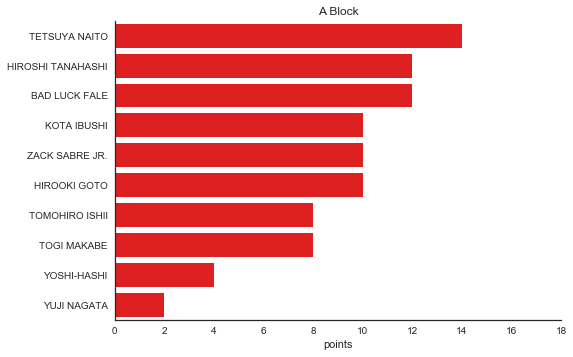

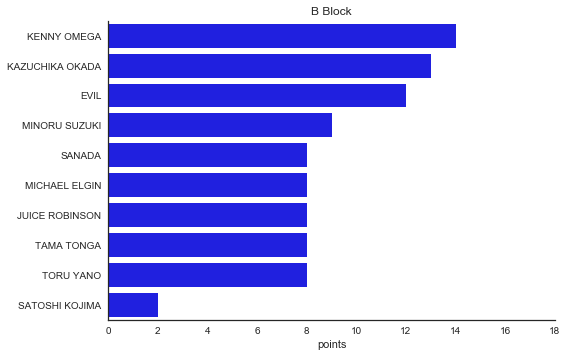

In [40]:

ax= sns.barplot(y='Wrestler', x='Points', data=A_Block, color= 'Red')
ax.set_xlim(0,18)
sns.despine()
ax.set_ylabel('')
ax.set_xlabel('points')
ax.set_title('A Block')
plt.show()
ax= sns.barplot(y='Wrestler', x='Points', data=B_Block,  color= 'Blue')
ax.set_xlim(0,18)
sns.despine()
ax.set_ylabel('') 
ax.set_xlabel('points')
ax.set_title('B Block')
plt.show()

The winner of the A_Block was Kenny Omega and the B Block was Tetsuya Naito who are two of the biggest wrestlers there so not a surprise*(Yes I know wrestling is fake as my wife keeps saying)*

Ok who was the highest rated star of the tournament

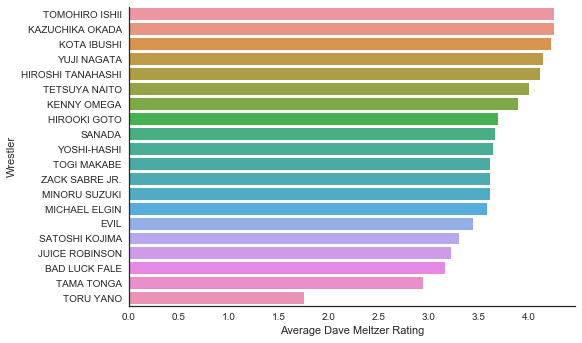

In [83]:
Combined = pd.concat([A_Block, B_Block])
Combined['Block'] = np.NAN
Combined.iloc[0:10,8] ="A Block"
Combined.iloc[10:20,8] ="B Block"
Combined = Combined.sort_values(['DMR'],ascending=False).reset_index(drop=True)
ax = sns.barplot(y='Wrestler', x='DMR',data=Combined)
sns.despine()
ax.set_xlabel('Average Dave Meltzer Rating')
plt.show()

Ok so the top two wrestlers were Tomohiro Ishii and Kazuchika Okada, where as Yano had the worst rating matches who is a comedy act but this is a little unfair

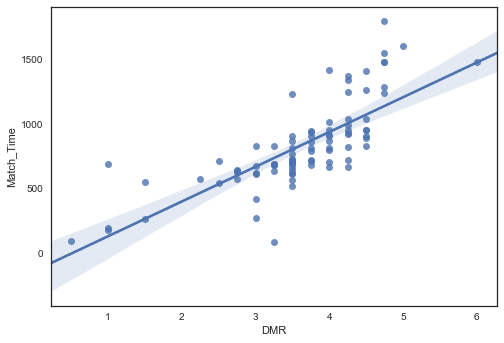

In [110]:
C_matches = pd.concat([A_matches, B_matches])
C_matches['Match_Time'] = C_matches['Match_Time'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
ax = sns.regplot(y='Match_Time', x='DMR',data=C_matches)
plt.show()

In [107]:
C_matches['Match_Time'] = C_matches['Match_Time'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

In [106]:
C_matches

Wrestler 1      Wrestler 2             Winner              Loser  \
0   HIROSHI TANAHASHI     TOGI MAKABE  HIROSHI TANAHASHI        TOGI MAKABE   
1   HIROSHI TANAHASHI  TOMOHIRO ISHII  HIROSHI TANAHASHI     TOMOHIRO ISHII   
2   HIROSHI TANAHASHI    HIROOKI GOTO  HIROSHI TANAHASHI       HIROOKI GOTO   
3   HIROSHI TANAHASHI     YOSHI-HASHI  HIROSHI TANAHASHI        YOSHI-HASHI   
4   HIROSHI TANAHASHI   BAD LUCK FALE  HIROSHI TANAHASHI      BAD LUCK FALE   
5   HIROSHI TANAHASHI     YUJI NAGATA  HIROSHI TANAHASHI        YUJI NAGATA   
6   HIROSHI TANAHASHI  ZACK SABRE JR.     ZACK SABRE JR.  HIROSHI TANAHASHI   
7   HIROSHI TANAHASHI     KOTA IBUSHI        KOTA IBUSHI  HIROSHI TANAHASHI   
8   HIROSHI TANAHASHI   TETSUYA NAITO      TETSUYA NAITO  HIROSHI TANAHASHI   
9         TOGI MAKABE  TOMOHIRO ISHII     TOMOHIRO ISHII        TOGI MAKABE   
10        TOGI MAKABE    HIROOKI GOTO        TOGI MAKABE       HIROOKI GOTO   
11        TOGI MAKABE     YOSHI-HASHI        TOGI MAKABE        YOSHI-HASHI   
12        TOGI MAKABE   BAD LUCK FALE      BAD LUCK FALE        TOGI MAKABE   
13        TOGI MAKABE     YUJI NAGATA        TOGI MAKABE        YUJI NAGATA   
14        TOGI MAKABE  ZACK SABRE JR.     ZACK SABRE JR.        TOGI MAKABE   
15        TOGI MAKABE     KOTA IBUSHI        TOGI MAKABE        KOTA IBUSHI   
16        TOGI MAKABE   TETSUYA NAITO      TETSUYA NAITO        TOGI MAKABE   
17     TOMOHIRO ISHII    HIROOKI GOTO       HIROOKI GOTO     TOMOHIRO ISHII   
18     TOMOHIRO ISHII     YOSHI-HASHI     TOMOHIRO ISHII        YOSHI-HASHI   
19     TOMOHIRO ISHII   BAD LUCK FALE      BAD LUCK FALE     TOMOHIRO ISHII   
20     TOMOHIRO ISHII     YUJI NAGATA     TOMOHIRO ISHII        YUJI NAGATA   
21     TOMOHIRO ISHII  ZACK SABRE JR.     ZACK SABRE JR.     TOMOHIRO ISHII   
22     TOMOHIRO ISHII     KOTA IBUSHI        KOTA IBUSHI     TOMOHIRO ISHII   
23     TOMOHIRO ISHII   TETSUYA NAITO     TOMOHIRO ISHII      TETSUYA NAITO   
24       HIROOKI GOTO     YOSHI-HASHI       HIROOKI GOTO        YOSHI-HASHI   
25       HIROOKI GOTO   BAD LUCK FALE      BAD LUCK FALE       HIROOKI GOTO   
26       HIROOKI GOTO     YUJI NAGATA       HIROOKI GOTO        YUJI NAGATA   
27       HIROOKI GOTO  ZACK SABRE JR.       HIROOKI GOTO     ZACK SABRE JR.   
28       HIROOKI GOTO     KOTA IBUSHI       HIROOKI GOTO        KOTA IBUSHI   
29       HIROOKI GOTO   TETSUYA NAITO      TETSUYA NAITO       HIROOKI GOTO   
..                ...             ...                ...                ...   
15          TORU YANO   MINORU SUZUKI          TORU YANO      MINORU SUZUKI   
16          TORU YANO     KENNY OMEGA        KENNY OMEGA          TORU YANO   
17     SATOSHI KOJIMA   MICHAEL ELGIN      MICHAEL ELGIN     SATOSHI KOJIMA   
18     SATOSHI KOJIMA  JUICE ROBINSON     JUICE ROBINSON     SATOSHI KOJIMA   
19     SATOSHI KOJIMA      TAMA TONGA         TAMA TONGA     SATOSHI KOJIMA   
20     SATOSHI KOJIMA          SANADA     SATOSHI KOJIMA             SANADA   
21     SATOSHI KOJIMA            EVIL               EVIL     SATOSHI KOJIMA   
22     SATOSHI KOJIMA   MINORU SUZUKI      MINORU SUZUKI     SATOSHI KOJIMA   
23     SATOSHI KOJIMA     KENNY OMEGA        KENNY OMEGA     SATOSHI KOJIMA   
24      MICHAEL ELGIN  JUICE ROBINSON     JUICE ROBINSON      MICHAEL ELGIN   
25      MICHAEL ELGIN      TAMA TONGA         TAMA TONGA      MICHAEL ELGIN   
26      MICHAEL ELGIN          SANADA             SANADA      MICHAEL ELGIN   
27      MICHAEL ELGIN            EVIL      MICHAEL ELGIN               EVIL   
28      MICHAEL ELGIN   MINORU SUZUKI      MICHAEL ELGIN      MINORU SUZUKI   
29      MICHAEL ELGIN     KENNY OMEGA      MICHAEL ELGIN        KENNY OMEGA   
30     JUICE ROBINSON      TAMA TONGA         TAMA TONGA     JUICE ROBINSON   
31     JUICE ROBINSON          SANADA             SANADA     JUICE ROBINSON   
32     JUICE ROBINSON            EVIL               EVIL     JUICE ROBINSON   
33     JUICE ROBINSON   MINORU SUZUKI      MINORU SUZUKI     